<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/karlguen/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW5: Star Classification Using Machine Learning



## Step 0: Enabling GPU Acceleration & Introduction to Machine Learning


In [78]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


.




## 1. Install Required Libraries

In [34]:
!pip install astropy scikit-learn tensorflow matplotlib numpy photutils auto-stretch

## 2. Load and Stretch the RGB FITS Image
We first load astronomic pictures ([FITS file format](https://en.wikipedia.org/wiki/FITS?wprov=sfti1#)) and apply a **stretching function** (logarithmic/asinh) to enhance visibility. The general problem is that in general Astrononomic pictures are stored using 32-bit integer, while your display is only able to show 8-bot integer color range. So we have to tell the computer what to do with the missing colors.

**ToDo**: Load and plot your assiged fits file (4 points)

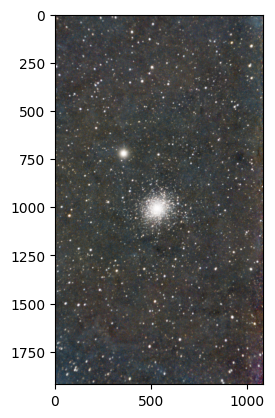

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from auto_stretch import apply_stretch
from sklearn.cluster import KMeans
import requests
from io import BytesIO

# Replace this URL with the raw URL of your FITS file on GitHub
fits_url = "https://github.com/ubsuny/PHY386/raw/refs/heads/main/data/4.fits"

# Fetch the FITS file from the GitHub repository
response = requests.get(fits_url)
response.raise_for_status()  # Check for request errors

# Load the FITS file into an HDUList using BytesIO
hdul = fits.open(BytesIO(response.content))

# Assume the first extension contains an RGB image in (3, Height, Width) format
rgb_data = np.transpose(hdul[0].data, (1, 2, 0))  # Shape should be (3, Height, Width)
hdul.close() #

# Display the image
fig = plt.figure()
plt.imshow(apply_stretch(rgb_data))

## 3. Count Stars Using Astropy
We use **DAOStarFinder** to detect and count stars.

**ToDo**: Extract the RGB channels seperately (4 points) and find an algorithm that makes the number of the detected stars in each channel the same (4 points). Plot the combined and the three RGB channels in a 2x2 grid plot highlighting the detecting stars.(4 points)

Depending on your fits file you might have to select a part of the image for star detection.

In [36]:
# calculate the mean of the RGB channels
avg_channel = np.mean(rgb_data[:, :, :], axis=2)


def detect_stars(channel_data):
    mean, median, std = sigma_clipped_stats(channel_data, sigma=3.0)
    finder = DAOStarFinder(fwhm=3.0, threshold=5.0*std, brightest=1000)   # CHANGE THIS TO REFINE THE MODEL OR LOOK IN PHOTUTILS DOCUMENTS (DAO STAR FINDER)
    sources = finder(channel_data - median)
    return finder(channel_data - median)
"""
   Detects stars in a 2D image using the DAOStarFinder algorithm.

    This function estimates the background statistics of the image using
    sigma-clipped statistics, then identifies star-like sources based on
    a Full Width at Half Maximum (FWHM) and a signal threshold.

    Parameters
    ----------
    channel_data : array_like
        A 2D NumPy array representing a single image channel (e.g., from a FITS image)
        where stars are to be detected. Pixel intensities should be linear (not log-scaled)
        and background-subtracted if possible.

    Returns
    -------
    astropy.table.Table
        A table of detected star sources, each with properties such as centroid
        positions, flux, sharpness, and roundness. Returns an empty table if no
        stars are found.

    Notes
    -----
    - Uses sigma-clipped statistics to robustly estimate the background mean,
      median, and standard deviation, excluding outliers like bright stars.
    - The DAOStarFinder algorithm identifies point sources based on their
      shape and brightness.
    - The detection threshold is set to 15 times the estimated background
      standard deviation, and the assumed FWHM of stars is 3 pixels.

    Examples
    --------
    >>> from astropy.io import fits
    >>> from astropy.stats import sigma_clipped_stats
    >>> from photutils.detection import DAOStarFinder
    >>> image_data = fits.getdata('example_image.fits')
    >>> stars = detect_stars(image_data)
    >>> print(len(stars))  # Number of stars detected
    """

# Detect stars
avg_sources = detect_stars(avg_channel)
print(f"Average number of detected stars: {len(avg_sources)}")# calculate the mean of the RGB channels

Average number of detected stars: 1000


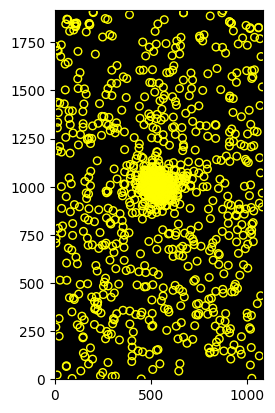

In [76]:
# Plot average detected stars
plt.imshow(avg_channel, cmap='gray', origin='lower')
plt.scatter(avg_sources['xcentroid'], avg_sources['ycentroid'], s=30, edgecolor='yellow', facecolors='none')
plt.show()

**Using this code for finding the average, we can also use this to find the number of detected stars in each RGB channel**

We proceed to do this for each color and then will show all of the different colors in one plot.



In [37]:
#Finding the red color channels
red_channel = rgb_data[:, :, 0]  # Set the RGB index to 0 to get red, it also doesn't need to be a mean

# Detect red stars
red_sources = detect_stars(red_channel)
print(f"Number of red detected stars: {len(red_sources)}")



#Finding the green color channels
gr_channel = rgb_data[:, :, 1]  # Set the RGB index to 1 to get green

# Detect green stars
gr_sources = detect_stars(gr_channel)
print(f"Number of green detected stars: {len(gr_sources)}")



#Finding the blue color channels
blue_channel = rgb_data[:, :, 2]  # Set the RGB index to 2 to get blue

# Detect blue stars
blue_sources = detect_stars(blue_channel)
print(f"Number of blue detected stars: {len(blue_sources)}")

Number of red detected stars: 1000
Number of green detected stars: 1000
Number of blue detected stars: 1000


Note from first attempt: The numbers are overall way different from each other. I'm going to adjust the threshold back down to 5 from 15
Note after change was made: It worked! All color channels now show the same number of 1000 stars, as required per the instructions.

## **Displaying all the different color channels**

Now we will use the average channel code that displays the channels and change
to use it for all our different color channels

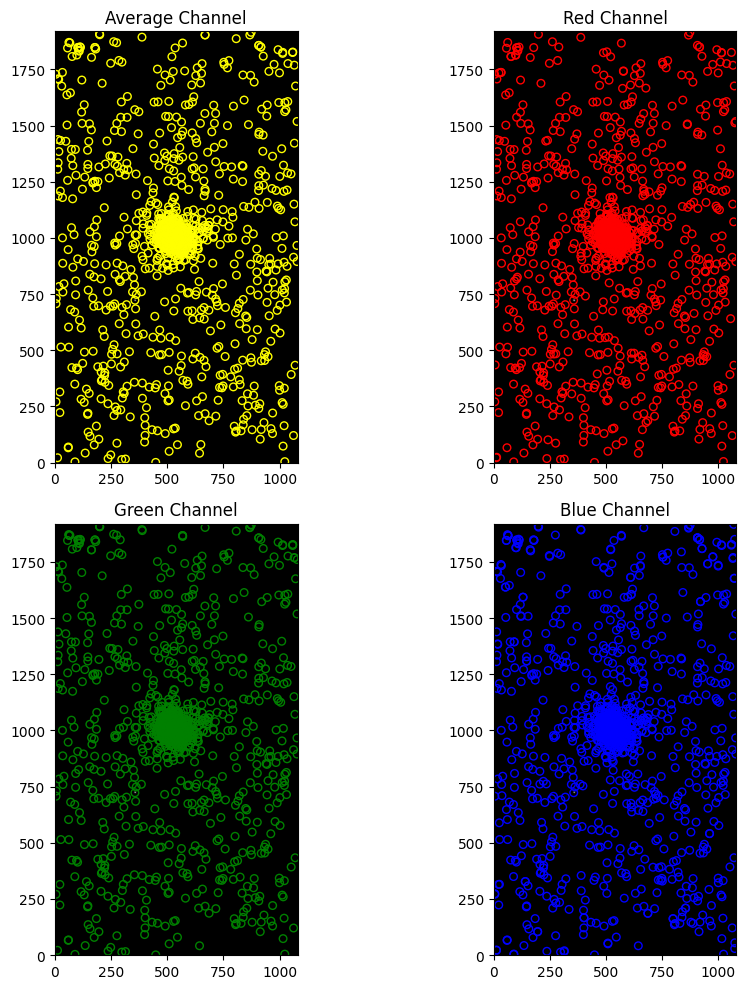

In [77]:
import matplotlib.pyplot as plt

# Create a figure and a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot average detected stars
axs[0, 0].imshow(avg_channel, cmap='gray', origin='lower')
axs[0, 0].scatter(avg_sources['xcentroid'], avg_sources['ycentroid'], s=30, edgecolor='yellow', facecolors='none')
axs[0, 0].set_title('Average Channel')

# Plot red detected stars
axs[0, 1].imshow(red_channel, cmap='gray', origin='lower')
axs[0, 1].scatter(red_sources['xcentroid'], red_sources['ycentroid'], s=30, edgecolor='red', facecolors='none')
axs[0, 1].set_title('Red Channel')

# Plot green detected stars
axs[1, 0].imshow(avg_channel, cmap='gray', origin='lower')
axs[1, 0].scatter(gr_sources['xcentroid'], gr_sources['ycentroid'], s=30, edgecolor='green', facecolors='none')
axs[1, 0].set_title('Green Channel')

# Plot blue detected stars
axs[1, 1].imshow(blue_channel, cmap='gray', origin='lower')
axs[1, 1].scatter(blue_sources['xcentroid'], blue_sources['ycentroid'], s=30, edgecolor='blue', facecolors='none')
axs[1, 1].set_title('Blue Channel')

plt.tight_layout()
plt.show()

# **Additonal Infomation about data and extra testing**

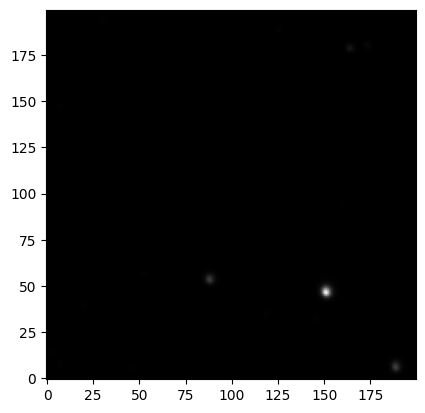

In [8]:
star_num = 400
region = 200
plt.imshow(avg_channel[int(sources['xcentroid'][star_num]-region//2):int(sources['xcentroid'][star_num]+region//2), \
            int(sources['xcentroid'][star_num]-region//2):int(sources['xcentroid'][star_num]+region//2)],\
           cmap='gray', origin='lower')

In [ ]:
hdul[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                 2160 / length of data axis 1                          
NAXIS2  =                 3840 / length of data axis 2                          
NAXIS3  =                    3 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =               32768. / offset data range to that of unsigned short    
BSCALE  =                   1. / default scaling factor                         
INSTRUME= 'Seestar S30'        / instrument name                                
TELESCOP= 'S30_5598e95f'    

In [ ]:
from astropy.wcs import WCS
wcs = WCS(hdul[0].header, naxis=2)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : '' '' 
CRVAL : 40.4305587437 61.3391758738 
CRPIX : 1204.875152588 1910.9397583 
PC1_1 PC1_2  : -0.00782250505024374 -0.999872224714258 
PC2_1 PC2_2  : 1.000064535622 -0.00808110327290437 
CDELT : 0.00110938929413406 0.0011092837626524 
NAXIS : 2160  3840  3

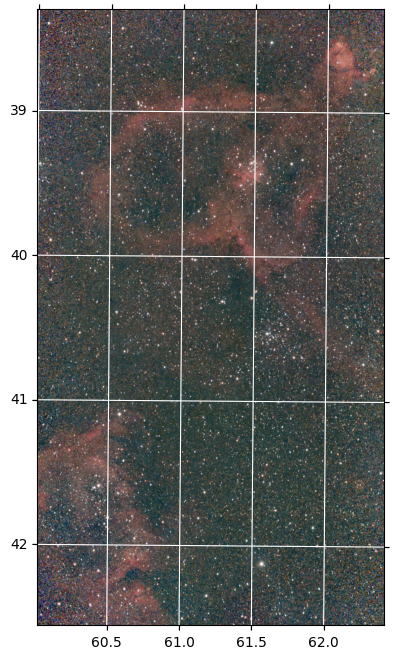

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=wcs)
ax.imshow(apply_stretch(rgb_data), origin='lower')
ax.coords.grid(color='white', ls='solid')

# Step 3: Feature Extraction



We extract:
- **Brightness (flux)** from each RGB channel.
- **Color Ratios**: R/G and B/G ratios to capture color differences.
- **Size Proxy** from sharpness values.
We normalize the extracted features for efficient learning.

**ToDo**: calculate the color ratios (4 points) and normalized flux ratios (4 points) for each color channel (R/G and B/G) for further analysis and generate a new `features` variable (4 points).

If you have very bright stars in your fits file you might have to use the `remove_extreme_brightness` function.

### Average Color Channel

In [41]:
# Extract features (brightness and size)
avg_flux = avg_sources['flux']

# Compute size proxy
avg_size = avg_sources['sharpness']

# Normalize features
flux_norm = (avg_flux - np.min(avg_flux)) / (np.max(avg_flux) - np.min(avg_flux))
size_norm = (avg_size - np.min(avg_size)) / (np.max(avg_size) - np.min(avg_size))

avg_features = np.vstack([flux_norm, size_norm]).T
# features = np.vstack([flux, size]).T

### Red Color Channel

In [42]:
# Extract features (brightness and size)
red_flux = red_sources['flux']

# Compute size proxy
red_size = red_sources['sharpness']

# Normalize features
red_flux_norm = (red_flux - np.min(red_flux)) / (np.max(red_flux) - np.min(red_flux))
red_size_norm = (red_size - np.min(red_size)) / (np.max(red_size) - np.min(red_size))

red_features = np.vstack([red_flux_norm, red_size_norm]).T

### Green Color Channel

In [43]:
# Extract features (brightness and size)
gr_flux = gr_sources['flux']

# Compute size proxy
gr_size = gr_sources['sharpness']

# Normalize features
gr_flux_norm = (gr_flux - np.min(gr_flux)) / (np.max(gr_flux) - np.min(gr_flux))
gr_size_norm = (gr_size - np.min(gr_size)) / (np.max(gr_size) - np.min(gr_size))

gr_features = np.vstack([gr_flux_norm, gr_size_norm]).T

### Blue Color Channel

In [44]:
# Extract features (brightness and size)
blue_flux = blue_sources['flux']

# Compute size proxy
blue_size = blue_sources['sharpness']

# Normalize features
blue_flux_norm = (blue_flux - np.min(blue_flux)) / (np.max(blue_flux) - np.min(blue_flux))
blue_size_norm = (blue_size - np.min(blue_size)) / (np.max(blue_size) - np.min(blue_size))

blue_features = np.vstack([blue_flux_norm, blue_size_norm]).T

### Calculating the color ratios and normalized flux ratios for each color channel (R/G and B/G)

In [56]:
# Calculate color ratios
rg_ratio = red_flux / gr_flux
bg_ratio = blue_flux / gr_flux

# Calculate normalize color ratios
rg_ratio_norm = (rg_ratio - np.min(rg_ratio)) / (np.max(rg_ratio) - np.min(rg_ratio))
bg_ratio_norm = (bg_ratio - np.min(bg_ratio)) / (np.max(bg_ratio) - np.min(bg_ratio))

# Create rgb_features array
rgb_features = np.vstack([rg_ratio_norm, bg_ratio_norm]).T

Therefore, we have calculated the color ratios for R/G and B/G, we have calculated the normalized flux rations for R/G and B/G, and created a new features array. So, all the ToDo is complete.

### Brightness function

In [ ]:
def remove_extreme_brightness(star_features, brightness_threshold=3.0):
    """
    Filters out stars with exceptionally high brightness from a dataset of star features.

    This function calculates the overall brightness of each star by computing the Euclidean norm
    of its feature vector. It then determines the mean and standard deviation of these brightness
    values. Stars whose brightness exceeds the mean by more than a specified number of standard
    deviations (defined by `brightness_threshold`) are considered outliers and removed from the dataset.

    Parameters
    ----------
    star_features : ndarray
        A 2D NumPy array of shape (n_stars, n_features), where each row represents the feature vector
        of a star. It is assumed that the features are numerical and relevant to the brightness calculation.
    brightness_threshold : float, optional
        The number of standard deviations above the mean brightness to use as the cutoff for identifying
        extreme brightness values. The default is 3.0, which corresponds to the common statistical practice
        of removing data points that lie more than three standard deviations from the mean.

    Returns
    -------
    filtered_star_features : ndarray
        A 2D NumPy array containing the feature vectors of stars that are not considered extreme in brightness.
    filtered_indices : ndarray
        A 1D boolean NumPy array indicating which stars were retained (True) and which were filtered out (False).

    Notes
    -----
    - The function assumes that the Euclidean norm of the feature vectors is an appropriate measure of
      brightness. Ensure that the input features are scaled or selected accordingly.
    - This method uses a statistical approach to identify outliers based on the assumption of a normal
      distribution of brightness values. If the brightness distribution is significantly non-normal,
      consider using alternative outlier detection methods.
    - The function utilizes NumPy's `linalg.norm` to compute the Euclidean norm and `mean` and `std`
      functions to calculate statistical measures.

    Examples
    --------
    >>> import numpy as np
    >>> star_features = np.array([[1.0, 2.0], [2.0, 2.0], [10.0, 10.0]])
    >>> filtered_features, filtered_indices = remove_extreme_brightness(star_features)
    >>> filtered_features
    array([[1., 2.],
           [2., 2.]])
    >>> filtered_indices
    array([ True,  True, False])
    """

    brightness = np.linalg.norm(star_features, axis=1)  # Compute overall brightness
    mean_brightness = np.mean(brightness)
    std_brightness = np.std(brightness)
    filtered_indices = brightness < (mean_brightness + brightness_threshold * std_brightness)
    return star_features[filtered_indices], filtered_indices

# Step 4: Autoencoder for Feature Compression


### Network Architecture:
- **Input Layer**: Takes in two features (brightness and size).
- **Encoder**:
  - A hidden layer with 8 neurons extracts patterns.
  - A bottleneck layer with 2 neurons compresses the data.
- **Decoder**:
  - Expands data back to 8 neurons.
  - Outputs the reconstructed 2-feature data.

**ToDo**: Adapt the input and output shape to the new feature generated above (4 points) and use the GPU for acceleration (2 points).

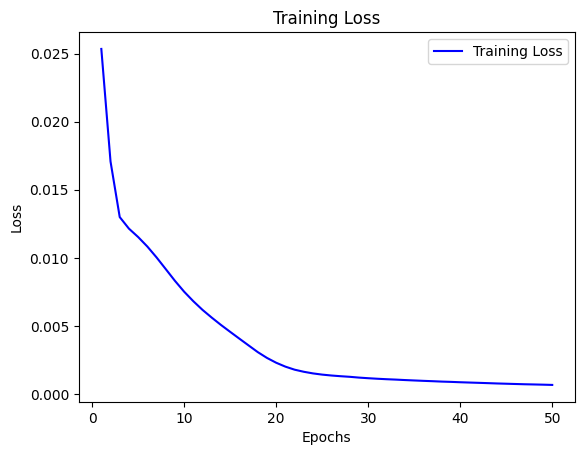

In [71]:
# Define an autoencoder model
input_layer = Input(shape=(2,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(2, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(2, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
history = autoencoder.fit(rgb_features, rgb_features, epochs=50, batch_size=16, verbose=0)

loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Step 5: Clustering with KMeans
After extracting compressed features, we use **KMeans clustering** to classify the stars.

In [72]:
encoder = Model(input_layer, encoded)
encoded_features = encoder.predict(rgb_features)

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
predicted_labels = kmeans.fit_predict(encoded_features)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


## Step 6a: Generating Synthetic Star Data
To demonstrate clustering in astrophysics, we generate synthetic stars with controlled properties.
This helps visualize how clustering can be applied to real astrophysical problems, such as distinguishing star populations.


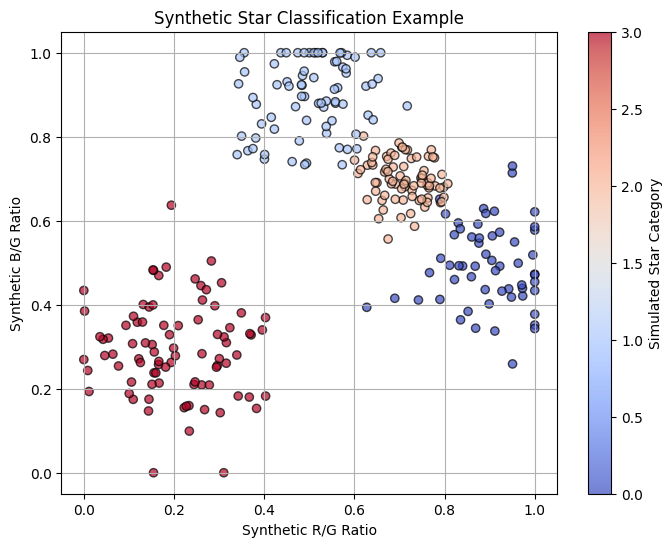

In [ ]:
import random

def generate_synthetic_stars(num_stars=300):
    """Generates synthetic star data with predefined color and brightness properties."""
    categories = {
        0: {'rg': 0.9, 'bg': 0.5, 'scatter': 0.1},  # Red stars
        1: {'rg': 0.5, 'bg': 0.9, 'scatter': 0.1},  # Blue stars
        2: {'rg': 0.7, 'bg': 0.7, 'scatter': 0.05}, # White stars
        3: {'rg': 0.2, 'bg': 0.3, 'scatter': 0.1},  # Dim stars
    }

    stars = []
    labels = []

    for _ in range(num_stars):
        category = random.choice(list(categories.keys()))
        base = categories[category]
        rg = max(0, min(1, np.random.normal(base['rg'], base['scatter'])))
        bg = max(0, min(1, np.random.normal(base['bg'], base['scatter'])))
        stars.append([rg, bg])
        labels.append(category)

    return np.array(stars), np.array(labels)

# Generate and plot synthetic stars
synthetic_stars, synthetic_labels = generate_synthetic_stars()
plt.figure(figsize=(8,6))
plt.scatter(synthetic_stars[:,0], synthetic_stars[:,1], c=synthetic_labels, cmap='coolwarm', alpha=0.7, edgecolors='k')
plt.xlabel('Synthetic R/G Ratio')
plt.ylabel('Synthetic B/G Ratio')
plt.colorbar(label='Simulated Star Category')
plt.title('Synthetic Star Classification Example')
plt.grid(True)
plt.show()

# Step 6b: Visualizing real data
We plot stars with different colors representing their assigned clusters.

Clusters represent groups of stars with similar size and brightness. If clusters overlap too much, it might indicate the need for better feature separation.

**ToDo**: Generate new plots from the new clustering for the cololr ratio and size/brightness (8 points)
- **X-axis: Normalized R/G Ratio** – Represents how red the star is relative to green.
- **Y-axis: Normalized B/G Ratio** – Represents how blue the star is relative to green.
- **Point Color: Cluster Label** – Assigned cluster based on autoencoder features and KMeans.

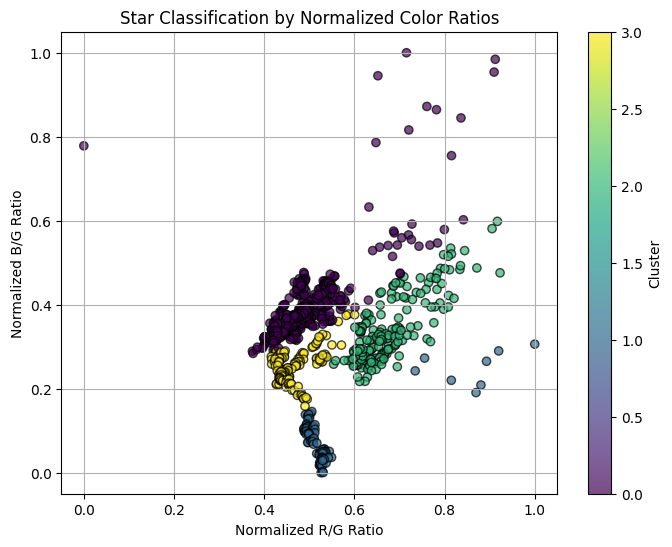

In [75]:
plt.figure(figsize=(8,6))
plt.scatter(rg_ratio_norm, bg_ratio_norm, c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized R/G Ratio')
plt.ylabel('Normalized B/G Ratio')
plt.colorbar(label='Cluster')
plt.title('Star Classification by Normalized Color Ratios')
plt.grid(True)
plt.show()

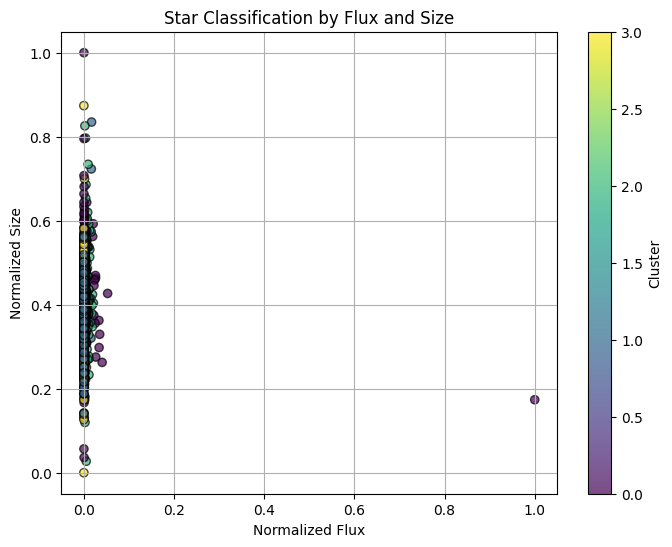

In [79]:
plt.figure(figsize=(8,6))
plt.scatter(flux_norm, size_norm, c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized Flux')
plt.ylabel('Normalized Size')
plt.colorbar(label='Cluster')
plt.title('Star Classification by Flux and Size')
plt.grid(True)
plt.show()

# Step 7: Refining the Clustering
To improve clustering, we:
1. **Increase Number of Clusters** – To separate stars into more detailed groups.
2. **Use Gaussian Mixture Model (GMM)** – A probabilistic alternative to KMeans for soft clustering.

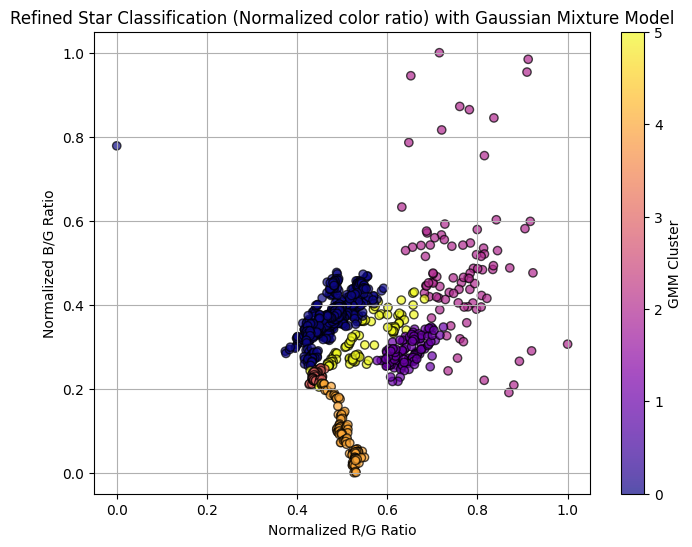

In [82]:
from sklearn.mixture import GaussianMixture

# Try different numbers of clusters
num_clusters_gmm = 6
gmm = GaussianMixture(n_components=num_clusters_gmm, random_state=42)
predicted_labels_gmm = gmm.fit_predict(encoded_features)

plt.figure(figsize=(8,6))
plt.scatter(rg_ratio_norm, bg_ratio_norm, c=predicted_labels_gmm, cmap='plasma', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized R/G Ratio')
plt.ylabel('Normalized B/G Ratio')
plt.colorbar(label='GMM Cluster')
plt.title('Refined Star Classification (Normalized color ratio) with Gaussian Mixture Model')
plt.grid(True)
plt.show()

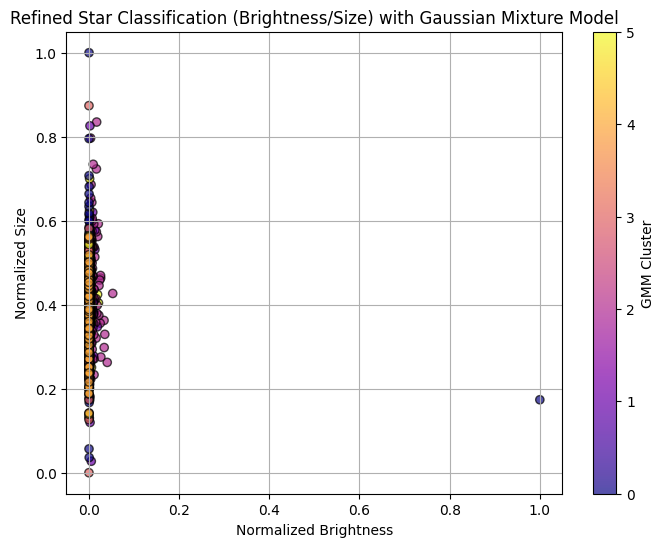

In [81]:
from sklearn.mixture import GaussianMixture

# Try different numbers of clusters
num_clusters_gmm = 6
gmm = GaussianMixture(n_components=num_clusters_gmm, random_state=42)
predicted_labels_gmm = gmm.fit_predict(encoded_features)

plt.figure(figsize=(8,6))
plt.scatter(flux_norm, size_norm, c=predicted_labels_gmm, cmap='plasma', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized Brightness')
plt.ylabel('Normalized Size')
plt.colorbar(label='GMM Cluster')
plt.title('Refined Star Classification (Brightness/Size) with Gaussian Mixture Model')
plt.grid(True)
plt.show()

# **Overall Conclusions**

As of right now, the clustering and normalized brightness levels make sense. There are a large number of very bright stars in the middle of the picture and several smaller/dimmer stars that can easily be seen within the picture. I made the assumption that the middle cluster of stars in the original image is simply that - many stars right next to each other. If this actually turns out to be one large star, I would then have had to use the reduce brigtness function that was provided.
Also, when determining the